In [90]:
# Libraries
%matplotlib inline
import pandas as pd
import shapefile as shp
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd 
from geopandas.tools import sjoin # Requires build from github for correct version
from shapely import geometry
import numpy as np
import os
import pysal as ps
import random

DATA_DIR = 'data/'
FIGURE_DIR = 'plots/'

SHAPE_FILE = 'CENSUS2010TOWNS_SHP/CENSUS2010TOWNS_POLY.shp'
CHILD_CARE_DATA = 'data/child_care_data1.csv'
CHILD_LAT = 'Latitude'
CHILD_LONG = 'Longitude'
CENSUS_DATA = 'data/census_data.csv'
GEO_COL = 'COUSUBFP10'
POINT_PROJECTION = 4326 #Projection for lat/longs
GEOMETRY = 'geometry' # Column name for geometery data
# Default CRS assuming census tiger tracts with NAD83 projections, found from prior work
DEFAULT_CRS = {'datum': 'NAD83','k': 0.999975, 'lat_0': 36.66666666666666,'lon_0': -88.33333333333333,
 'no_defs': True,'proj': u'tmerc',u'units': u'us-ft',u'x_0': 300000, u'y_0': 0} 
    

In [184]:
# Data Preparation

# Build data tied with geographic boundaries

shape_df = gpd.read_file(SHAPE_FILE)
if shape_df.crs == {}:
    shape_df = gpd.GeoDataFrame(shape_df,crs=DEFAULT_CRS)
    
shape_df[GEOMETRY] = shape_df[GEOMETRY].to_crs(epsg=POINT_PROJECTION)
shape_df = gpd.GeoDataFrame(shape_df,crs=None) #Remove crs so join completes

# Create dataframe with childcare information, remove points not in the area or null, join to town data
child_df = build_points(CHILD_CARE_DATA,CHILD_LAT,CHILD_LONG)

child_df = point_out_of_bounds(child_df,shape_df)
child_df = sjoin(child_df,shape_df,how='left')
# Get age from initial issue date
child_df['age'] = pd.to_datetime(child_df['FirstIssueDate']).apply(lambda x: pd.to_datetime('today').year - x.year) # convert age

# Split out financial assitance columns
financial_cols = dummy_list_col(child_df,'FinancialAssistance',';')
# Run analysis across child care centers
child_care_analysis(child_df,financial_cols)

# Build town level data and join in relevant data from child care dataset
census_df = join_census_files()
town_data = pd.merge(census_df,shape_df,left_on=GEO_COL.lower(),right_on=GEO_COL)
town_data.index = town_data[GEO_COL]
town_data = clean_town_data(town_data, child_df)



Empty DataFrame
Columns: []
Index: [00170, 00380, 00520, 00555, 00840, 01260, 01325, 01465, 01605, 01885, 01955, 02095, 02130, 02480, 02690, 02760, 02935, 03005, 03690, 03740, 04545, 04615, 04825, 04930, 05070, 05280, 05490, 05560, 05595, 05805, 06015, 06085, 06365, 07000, 07175, 07350, 07420, 07525, 07740, 07980, 08085, 08470, 09000, 09105, 09175, 09595, 09840, 11000, 11315, 11525, 11665, 12505, 12715, 12995, 13135, 13205, 13345, 13485, 13590, 13660, 13800, 14010, 14395, 14640, 14885, 15060, 15200, 16180, 16250, 16425, 16495, 16670, 16775, 16950, 17300, 17405, 17475, 17685, 17825, 17895, 18455, 18560, 19295, 19370, 19645, 20100, 21150, 21360, 21780, 21850, 21990, 22130, 23000, 23105, 23875, 24820, 24925, 25172, 25240, 25485, ...]

[318 rows x 0 columns]
Island ids:  [117, 178]


In [213]:
financial_cols = [x for x in child_df.columns if 'FinancialAssistance_' in x]
print(financial_cols)

[]


In [168]:
col = town_data['under_10_vs_capacity']
rank_col = col.rank() 
rank_col = (rank_col / rank_col.max()).apply(lambda x: 1 - round(x,2))
print(rank_col)

COUSUBFP10
03690    0.29
07175    0.33
07980    0.17
12995    0.40
16775    0.46
19295    0.34
23105    0.44
29020    0.81
39100    0.59
51440    0.12
55500    0.95
59735    0.78
70605    0.25
74385    0.08
82525    0.71
00555    0.24
00975    0.95
04545    0.64
13345    0.52
14010    0.78
16180    0.18
21360    0.77
24120    0.95
26815    0.26
28180    0.95
30315    0.73
34340    0.48
34655    0.55
34970    0.08
42460    0.95
         ... 
45105    0.95
46820    0.31
46925    0.65
47135    0.77
50670    0.19
51825    0.52
52420    0.70
53120    0.05
53225    0.03
55395    0.89
58580    0.90
58825    0.20
61800    0.65
63165    0.19
63345    0.64
66105    0.55
67385    0.32
68155    0.57
68610    0.74
69275    0.41
71480    0.84
71620    0.66
73090    0.82
73895    0.59
75015    0.05
75155    0.49
75400    0.87
77010    0.56
80405    0.67
82000    0.59
Name: under_10_vs_capacity, dtype: float64


In [214]:
def clean_town_data(town_data, child_df,financial_cols):

    center_cnt = child_df.groupby([GEO_COL]).count()['ProgramName'] # count of centers
    center_cap = child_df.groupby([GEO_COL]).sum()['Capacity'] # total capacity of centers
    town_data = town_data.join(center_cnt)
    town_data = town_data.join(center_cap)
    
    # Get count of types of assistance in a town
    financial_data = child_df.groupby([GEO_COL]).sum()[financial_cols]
    print(financial_data)
    #town_data = town_data.join(financial_data)
    
    town_data.rename(columns={'ProgramName':'center_count'},inplace=True)
    

    # Set towns with no entries in child care data to 0 for capacity and program name
    town_data[['Capacity','center_count']] = town_data[['Capacity','center_count']].fillna(0)

    # Get nearby towns based on shared boundary
    get_nearby_town_info(town_data)
    add_age_categories(town_data)
    add_proportion_columns(town_data)
    
    return town_data

def get_nearby_town_info(town_data):
    # Adds capacity and count of centers in nearby towns using neighbor calculation from pysal library
    num_centers = []
    capacity = []
    w = ps.weights.user.queen_from_shapefile(SHAPE_FILE,idVariable=GEO_COL)
    for town_id in town_data.index:

        neighbors = w.neighbors[town_id]

        # Get sum total of centers and capacity in neighboring towns
        capacity.append(int(town_data.ix[neighbors,['Capacity']].sum()))
        num_centers.append(int(town_data.ix[neighbors,['center_count']].sum()))
    
    town_data['nearby_capacity'] = capacity
    town_data['nearby_centers'] = num_centers
    
def add_proportion_columns(town_data):
    
    # rename proportion columns and created consolidated columns
    divide_cols = {'under_5':['total_age_under_5_years_age'],'5_to_9':['total_age_5_to_9_years_age'],
                   '10_to_14':['total_age_10_to_14_years_age'],
                   'under_10':['total_age_under_5_years_age','total_age_5_to_9_years_age']}


    for numerator in  ['Capacity','center_count']:
        for key, value in divide_cols.items():
            
            # add custom total column where columns are being summed
            if len(value) > 1:
                town_data[key+'_total'] = town_data[value].sum(axis=1)

            town_data[key + '_vs_' + numerator.lower()] = town_data[numerator].divide(town_data[value].sum(axis=1))

def add_age_categories(town_data):
    
    town_data.rename(columns={'total_total_population_age':'total_population_age'},inplace=True)
    age_categories = [x for x in town_data.columns.tolist() if ('total_age' in x) or ('selected_age' in x)]
    
    # Convert to percent
    percent_age_categories = [x.replace('total_','percent_') for x in age_categories]
    town_data[percent_age_categories] = (town_data[age_categories].astype(float) / 100)
    
    # Get population totals 
    town_data[age_categories] = town_data[percent_age_categories].multiply(town_data['total_population_age'],axis=0)

In [6]:
def dummy_list_col(df,split_col,splitter):
    # converts a list in a cell to dummies based on the items in that list
    atom_cols = []
    for col in df[split_col]:
        try:
            # Split list and add all items that aren't already there, 
            items = col.split(splitter)
            for item in items:
                item = item.strip()
                inc = False
                for atom in atom_cols:
                    if item in atom: # String comparison to control for bad splits
                        inc = True
                        break
                if inc:
                    pass
                else:
                    atom_cols.append(item)

        except:
            pass
    
    dummies = pd.get_dummies(df[split_col])
    
    for atom_col in atom_cols:
        df[split_col + '_' + atom_col] = dummies[[x for x in dummies.columns if atom_col in x]].sum(axis=1)
    
    return [split_col + '_' + col for col in atom_cols]


In [201]:
def draw_relative_map(col_name,town_data,title,color):
    col = town_data[col_name]
    rank_col = col.rank() 
    col_name = col_name + '_rank'
    town_data[col_name] = (rank_col / rank_col.max()).apply(lambda x: 1 - round(x,2))

    plt.figure()


    low_patch = mpl.patches.Patch(fill=False,edgecolor='k', label='Lowest Ratio (10th percentile)')
    medium_patch = mpl.patches.Patch(color=color,alpha=.5, label='Median Ratio')
    high_patch = mpl.patches.Patch(color=color,alpha=1, label='Highest Ratio (90+ percentile)')
    plt.legend(handles=[low_patch,medium_patch,high_patch],loc=3)


    for row, shape in enumerate(town_data['geometry']):
        alpha = town_data.ix[row,col_name]
        try:
            x,y = shape.exterior.coords.xy
        except:
            shape_list = list(shape)
            for sub_shape in shape_list:
                x,y = sub_shape.exterior.coords.xy
                plt.fill(x,y,color=color,alpha=alpha)

        plt.fill(x,y,color=color,alpha=alpha)
    plt.gcf().set_size_inches(14,8)
    plt.title(title)
    plt.axis('off')
    plt.savefig(FIGURE_DIR + title + '.png')
    plt.show()

def child_care_analysis(df,financial_cols):
    '''
    Runs custom analysis on child care data, description statistics and graphing
    '''   
    
    
    # Basic statistics on key categories
    cols = ['age','Capacity','eMailAddress','MailingZipcode','FaxNumber','ProviderPhone']
    for col in cols:
        print(col)
        if df[col].dtype == 'O' or col == 'FaxNumber':
            print(round(df[col].count()/len(df[col]),2)*100,
                  '% of centers have logged an active', col,'\n')
        else:
            print(df[col].describe(),'\n')
            
         
    # Print information about type
    print("Center Type\n")
    print(child_df['ProgramType'].value_counts(),'\n')
    
          
    # Graph age distribution
    
    df['age'].hist(bins=20)
    plt.title("Age Distribution of Child Care Centers")
    plt.xlabel("Age of centers in years")
    plt.ylabel("Number of liscensed centers")
    plt.savefig(FIGURE_DIR + "age_distribution.png")
    plt.show()
    
        
    # graph capacity with cutoff bin at 100
    data = df['Capacity'].copy()
    cut_off = 100
    step = 5
    bins = list(range(0,cut_off+step*2,step))
    data[data > cut_off] = cut_off+1
    data.hist(bins=bins)
    plt.title("Capacity Distribution of Child Care Centers")
    plt.xlabel("Total Capacity")
    plt.ylabel("Number of liscensed centers")
    plt.xlim([0,cut_off+step])
    plt.xticks(bins,bins[:-2]+[str(cut_off)+'+',''],rotation=90)
    plt.savefig(FIGURE_DIR + "capacity_distribution.png")
    plt.show()
    
    # Analyze financial assistance
    
    
    # Get ordered list of types of financial assistance
    sorted_df = df[financial_cols].sum().sort_values(ascending=False)
    sorted_df = sorted_df[sorted_df > 50] # Drop all assistance less than 50 (<5 types)
    
    # plot
    labels = [x.replace("FinancialAssistance_",'') for x in sorted_df.index]
    plt.figure(1, figsize = (12, 8))
    plt.axes(aspect = 1)
    plt.pie(list(sorted_df),labels=labels,startangle = 0,
       labeldistance = 1.4,autopct = lambda x: '{:.0f} '.format(x * sum(sorted_df) / 100,x),pctdistance = 1.2)
    
    plt.title('Count of discounts offered by centers\n Offered in 50+ centers')
    plt.savefig(FIGURE_DIR + "discount_types.png")
    
    

In [3]:
def get_dataset_name(filename):
    # returns name for use in columns of final dataframe
    return os.path.basename(filename).replace('.csv','').replace('census_','')
    
def join_census_files():
    # Loops through all files and merges on geoid
    cen_files = [DATA_DIR  + x for x in os.listdir(DATA_DIR) if 'census' in x]

    df = pd.read_csv(cen_files[0],index_col='Id')
    data_set_name = get_dataset_name(cen_files[0])
    df.rename(columns=lambda x: x+'_'+data_set_name,inplace=True)    
    for filename in cen_files[1:]:
        new_df = pd.read_csv(filename,index_col='Id')
        data_set_name = get_dataset_name(filename)
        new_df.rename(columns=lambda x: x+'_'+data_set_name,inplace=True)
        
        df = df.join(new_df,how='left')
    
    return clean_census_data(df)

def clean_census_data(census_df):
    
    # Get town ID out of census provided ID
    census_df[GEO_COL] = [x[-5:] for x in census_df.index.tolist()]
    
    # Drop columns, margin of error, gender, information on imputation
    error_cols = [x for x in census_df.columns if 'Margin of Error' in x]
    # Gender
    gender_cols = [x for x in census_df.columns if ('Female;' in x) or ('Male;' in x)]
    # Imputation
    impute_cols = [x for x in census_df.columns if 'imputed' in x.lower()]
    # ID cols
    id_cols = [x for x in census_df.columns if ('Id2' in x) or ('Geography' in x)]
    # Drop
    census_df.drop(error_cols+gender_cols+impute_cols+id_cols,axis=1,inplace=True)
    
    # Make names uniform and reduce text
    census_df.rename(columns=lambda x: x.replace('Total; Estimate;','total')
                     .replace('Estimate; Total: - ','total_').replace('Estimate; Total:','total_').replace('Estimate; ','total_')
                     .replace('Median income (dollars); Estimate;','median_income'),inplace=True)
    census_df.rename(columns=lambda x:x.replace(' - ','_').replace(' ','_').replace('--','').replace('(','').replace(')','').
                     replace(',','').lower(),inplace=True)

    
    return census_df

In [209]:
town_data[town_data['Capacity'] == 0].columns.tolist()

['total_population_age',
 'total_age_under_5_years_age',
 'total_age_5_to_9_years_age',
 'total_age_10_to_14_years_age',
 'total_age_15_to_19_years_age',
 'total_age_20_to_24_years_age',
 'total_age_25_to_29_years_age',
 'total_age_30_to_34_years_age',
 'total_age_35_to_39_years_age',
 'total_age_40_to_44_years_age',
 'total_age_45_to_49_years_age',
 'total_age_50_to_54_years_age',
 'total_age_55_to_59_years_age',
 'total_age_60_to_64_years_age',
 'total_age_65_to_69_years_age',
 'total_age_70_to_74_years_age',
 'total_age_75_to_79_years_age',
 'total_age_80_to_84_years_age',
 'total_age_85_years_and_over_age',
 'total_selected_age_categories_5_to_14_years_age',
 'total_selected_age_categories_15_to_17_years_age',
 'total_selected_age_categories_18_to_24_years_age',
 'total_selected_age_categories_15_to_44_years_age',
 'total_selected_age_categories_16_years_and_over_age',
 'total_selected_age_categories_18_years_and_over_age',
 'total_selected_age_categories_60_years_and_over_age',
 '

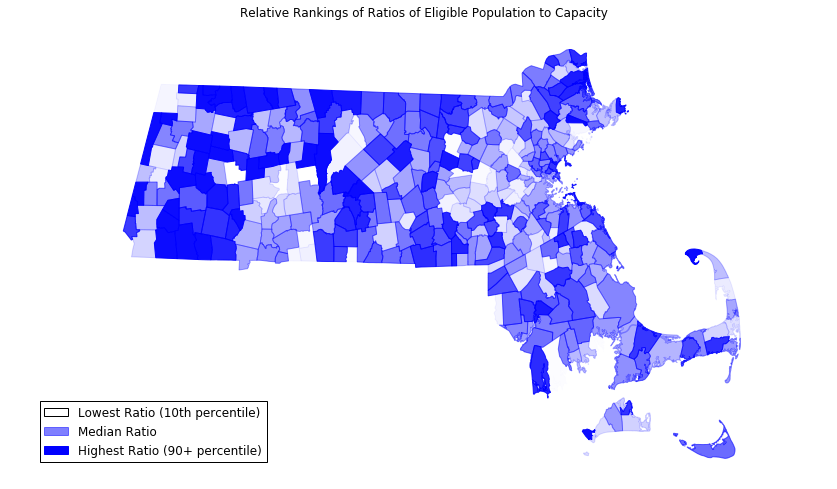

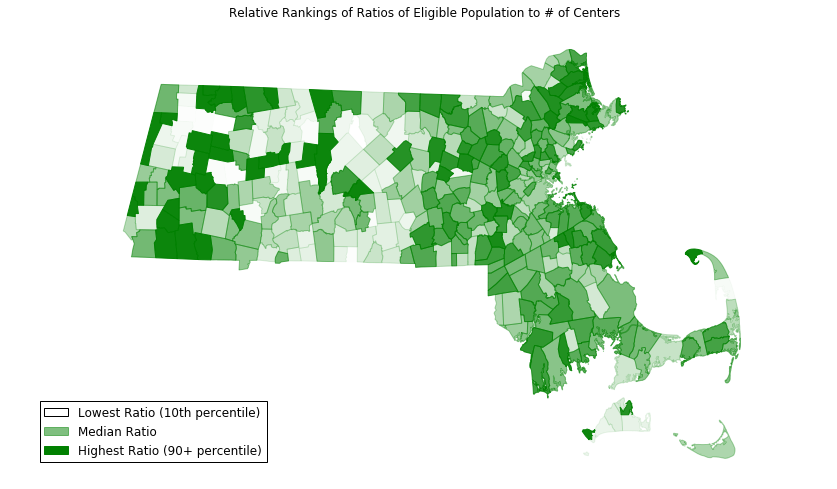

In [203]:
def town_analysis(town_data):
    cap_col_name = 'under_10_vs_capacity'
    cap_title = 'Relative Rankings of Ratios of Eligible Population to Capacity'
    cap_color = 'b'
    draw_relative_map(cap_col_name,town_data,cap_title,cap_color)

    cnt_col_name = 'under_10_vs_center_count'
    cnt_title = 'Relative Rankings of Ratios of Eligible Population to # of Centers'
    cnt_color = 'g'
    draw_relative_map(cnt_col_name,town_data,cnt_title,cnt_color)
    
    town_data



In [4]:
def build_points(filename,lat,long):
    '''
    Creates dataframe from file to join to shapefile
    '''
    point_df = pd.read_csv(filename)
    point_df = gpd.GeoDataFrame(point_df)
    #Add Points to df
    point_list = []
    for index, row in point_df.iterrows():
        point_list.append(geometry.Point(row[long],row[lat]))
    point_df[GEOMETRY] = point_list
    return point_df

def point_out_of_bounds(point_df, shape_df):
    '''
    Drops points that aren't in the bounded area or are Null
    '''
    minx, miny, maxx, maxy = shape_df.total_bounds
    #Drop Null & out of range points
    return point_df[(point_df[CHILD_LAT] > miny) & (point_df[CHILD_LAT] < maxy) & (point_df[CHILD_LONG] > minx) & (point_df[CHILD_LONG] < maxx)] 
    
